In [32]:
import sys
sys.path.append('../')

import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter

from src.utils import *
from dataset import *
from src.train import train, test
from src.dataloaders import make_dataloaders_from_dataset
from src.model import BaseEstimator, KnnEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(17)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
G = nx.readwrite.read_gpickle('data/network32.gpickle')

In [40]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_data = from_networkx(G, group_node_attrs=['embedding'])
pyg_data.to(device);

The main idea behind the extrapolation layer is considering observed and unobserved nodes as a bipartite graph, where each node belongs to the corresponding part(left -> observed, right -> unobserved). So an edge between two nodes defines that estimating target in unobserved location in the right part will be partly based on the observed node in the left part. Using that concept layer can be developed basing on the Message Passing principle.

Model specification:
$$T(a) = \sum_{b \in \mathcal{N_a} } T(b)w(a, b)\frac{scale(a)}{scale(b)}, \textrm{where summation is calculated for the {\bf k} nearest neighbors.}$$

$$ w(i, j)= \frac{exp(LeakyReLU(a^T[W x_i\parallel W x_j]))}{\sum_{k \in \mathcal{N_i}} exp(LeakyReLU(a^T[W x_i\parallel W x_k]))} ;$$

$scale(a)$ = mean target of location **a**

$x_a$ is an embedding for a node **a**;

So for this model $W, \vec{a}$ parameters are optimized.

In [35]:
class BasicLocationScaler(nn.Module):
    def __call__(self, X):
        return X


class ExtrapolationLayer(pyg.nn.MessagePassing):
    def __init__(self, in_channels, out_channels=1, hidden_channels=16, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.lin = nn.Linear(self.in_channels, self.hidden_channels)
        self.loc_scaler = BasicLocationScaler()
        self.a = nn.Parameter(torch.randn(self.hidden_channels * 2))
    

    def forward(self, obs_emb, obs_scaling_features, obs_targets, q_emb, q_scaling_features, edge_index):
        """Returns estimated targets for query nodes using scaling features and node embeddings.
        This function works utilizing message passing principle. For more information check the following link
        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

        Args:
            obs_emb (torch.Tensor): embeddings for observed nodes 
            obs_scaling_features (torch.Tensor): scaling features for observed nodes
            obs_targets (torch.Tensor): targets for observed nodes
            q_emb (torch.Tensor): embeddings for query nodes 
            q_scaling_features (torch.Tensor): scaling features for query nodes
            edge_index (torch.Tensor): edges for the bipartite graph

        Returns:
            torch.Tensor: estimated targets for query nodes
        """
        # print(obs_emb.shape)
        # print(q_emb.shape)
        # print(obs_scaling_features.shape)
        # print(q_scaling_features.shape)
        # print(obs_targets.shape)

        scale_obs = self.loc_scaler(obs_scaling_features)
        scale_q = self.loc_scaler(q_scaling_features)

        obs_emb = self.lin(obs_emb)
        q_emb = self.lin(q_emb)

        q_size = len(q_emb)
        obs_size = len(obs_emb)


        scaled_targets = (obs_targets / scale_obs).reshape(-1, 1)
        # scaled_targets = obs_targets.reshape(-1, 1)
        out = self.propagate(edge_index, x=scaled_targets, emb=(obs_emb, q_emb), size=(obs_size, q_size)).reshape(-1)
        out = out * scale_q
        # out = scale_q
        return out


    def message(self, x_j, emb_j, emb_i, index):
        # print(x_j.shape, emb_j.shape, emb_i.shape, index.shape)
        # alpha = torch.sum(emb_j * emb_i, dim=-1)[:, None]
        # print(emb_j.shape)
        # print(alpha.shape)
        # alpha = torch.cosine_similarity(emb_j, emb_i)[:, None]

        alpha = torch.hstack((emb_j, emb_i))
        alpha = torch.nn.functional.leaky_relu(torch.matmul(alpha, self.a[:, None]), negative_slope=0.2)

        att_weights = pyg.utils.softmax(alpha, index)
        out = att_weights * x_j
        return out
    
    def aggregate(self, inputs, index):
        return torch_scatter.scatter(inputs, index, dim=0, reduce='sum')


In [36]:
from sklearn.neighbors import NearestNeighbors


class GNNEstimator(BaseEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, nodes: List[str], targets: np.array, in_channels=32, *args, **kwargs):
        super().__init__(pyg_graph, nodes, targets, *args, **kwargs)

        self.obs_targets = torch.as_tensor(self.obs_targets).to(device)
        self.extrapolation_layer = ExtrapolationLayer(in_channels)    

    def forward(self, nodes, edge_index):
        """Returns estimated targets for the given nodes

        Args:
            nodes (List[str]): unobserved query nodes
            edge_index (torch.Tensor): edge index for bipartite graph

        Returns:
            torch.Tensor: estimated targets for query nodes
        """
        # here can be possible node features updating
        embeddings = self.g.x
        q_index = np.asarray([int(self.node_to_idx(x)) for x in nodes])

        obs_scaling_features = self.g.mean_target[self.obs_node_indices]
        q_scaling_features = self.g.mean_target[q_index]

        obs_emb = embeddings[self.obs_node_indices]
        q_emb = embeddings[q_index]

        return self.extrapolation_layer(obs_emb, obs_scaling_features, 
            self.obs_targets, q_emb, q_scaling_features, edge_index)
    
    def make_test_edge_index(self, query_graph: pyg.data.Data, neighbors_num=10):
        """Forms edge index for bipartite graph, where left part is observed nodes and the right one is query nodes.
        Edges are formed only for k nearest observed nodes(by geo distance).

        Args:
            query_graph (pyg.data.Data): node features of query graph.
            neighbors_num (int, optional): number of nearest neighbors to search. Defaults to 10.

        Returns:
            torch.Tensor: edge index for the bipartite graph.
        """
        nneighbors = NearestNeighbors(n_neighbors=neighbors_num, metric='haversine')

        nneighbors.fit(torch.vstack([self.g.lat[self.obs_node_indices],
                                     self.g.lon[self.obs_node_indices]]).T.detach().cpu())

        indices = nneighbors.kneighbors(torch.vstack([query_graph.lat, query_graph.lon]).T.detach().cpu(), 
                return_distance=False)
        
        index = torch.stack((torch.asarray(indices).reshape(-1), 
                             torch.arange(query_graph.num_nodes)[:, None].expand(-1, neighbors_num).reshape(-1)))
        return index

In [37]:
from random import Random

def node_indices_split(nodes_num, train_size=0.7, val_size=0.15, test_size=0.15):
    assert train_size + val_size + test_size == 1.0
    indices = np.arange(nodes_num)
    Random(34).shuffle(indices)
    train, val, test = map(torch.tensor, np.split(indices, [int(nodes_num*train_size), int(nodes_num*(train_size + val_size))]))
    return train, val, test

In [38]:
from tqdm import tqdm as tqdm
from sklearn.metrics import r2_score


def test(model, nodes, targets, edge_index, loss_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    total_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        out = model(nodes, edge_index)

        y_gpu = targets.to(device)
        loss = loss_fn(out, y_gpu)

        y_true.extend(targets)
        y_pred.extend(out.detach().cpu())
    
    return loss.item(), r2_score(y_true, y_pred)


def train(model, train_nodes, y_train, train_edge_index, val_nodes, y_val, val_edge_index, loss_fn,
          optimizer, device, scheduler=None, num_epochs=10, plot=True, plot_update_every=5):
    """ returns best model on validation
    """

    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []

    for epoch in range(num_epochs + 1):
        model.train()

        optimizer.zero_grad()
        out = model(train_nodes, train_edge_index)
        y_train_gpu = y_train.to(device)
        loss = loss_fn(out, y_train_gpu)
        loss.backward()
        optimizer.step()

        # print(y_train, out)
        # fuck()
   
        train_losses.append(loss.item())

        if scheduler is not None:
            scheduler.step()

        train_scores.append(r2_score(out.detach().cpu(), y_train.detach().cpu()))
        val_loss, val_score = test(model, val_nodes, y_val, val_edge_index, loss_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if plot and epoch > 0 and epoch % plot_update_every == 0:
            clear_output(True)
            _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=train_losses, label='Train', color='blue')
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=val_losses, label='Val', color='red')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()

            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=val_scores, label='Val', color='red')
            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=train_scores, label='Train', color='blue')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()

            plt.show()
            # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')

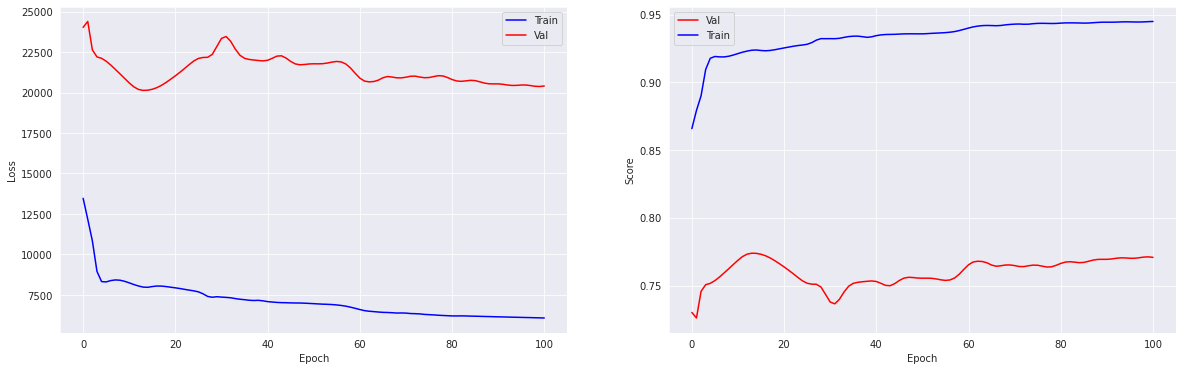

  0%|          | 0/15 [00:04<?, ?it/s]

2021-01-04, Test loss: 10750.0752, test score: 0.8918


In [39]:
results = dict()
loss_fn = nn.MSELoss().to(device)
model = None
NEIGHBORS_NUM = 25

for path in tqdm(glob.glob('datasets/*')[5:20]):
    day = path.split('/')[1].split('.')[0]
    print(day)

    try:
        ds = torch.load(path)
    except:
        continue
    

    train_nodes_idx, val_nodes_idx, test_nodes_idx = node_indices_split(len(ds))
    train_nodes, train_targets = ds[train_nodes_idx]
    val_nodes, val_targets = ds[val_nodes_idx]
    test_nodes, test_targets = ds[test_nodes_idx]
    y_train, y_val, y_test = map(torch.as_tensor, (train_targets, val_targets, test_targets)) 

    train_graph = pyg_data.subgraph(train_nodes_idx)
    val_graph = pyg_data.subgraph(val_nodes_idx)
    test_graph = pyg_data.subgraph(test_nodes_idx)

    model = GNNEstimator(pyg_data, train_nodes, train_targets).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)

    train_edge_index = pyg.nn.knn_graph(train_graph.x, k=NEIGHBORS_NUM, cosine=True) 
    val_edge_index = model.make_test_edge_index(val_graph, neighbors_num=NEIGHBORS_NUM).to(device)
    test_edge_index = model.make_test_edge_index(test_graph, neighbors_num=NEIGHBORS_NUM).to(device)
    
    train(model, train_nodes, y_train, train_edge_index, val_nodes, y_val, val_edge_index, 
          loss_fn, optimizer, device, num_epochs=100, plot=True, plot_update_every=10)

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_nodes, y_test, test_edge_index, loss_fn, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    results[f'{day}'] = test_score 
    print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')
    break